# ArcFace 모델 학습

ArcFace (Additive Angular Margin Loss)를 사용하여 필기체 작성자 인식 모델 학습
- 백본: Vision Transformer (ViT)
- Loss: ArcFace Loss
- 데이터: CSAFE 300명 작성자

In [1]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.cuda.amp import GradScaler, autocast  # Mixed Precision Training

import timm
import pandas as pd
import numpy as np
from PIL import Image
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc  # AUC 계산용
from sklearn.metrics.pairwise import cosine_similarity  # 코사인 유사도 계산용

# 재현성을 위한 시드 설정
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
import random
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# GPU 2번을 기본 디바이스로 설정
torch.cuda.set_device(2)

# GPU 설정 및 멀티GPU 확인
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
num_gpus = torch.cuda.device_count()
print(f'Using device: {device}')
print(f'Available GPUs: {num_gpus}')

# 사용할 GPU 리스트 정의 (2, 3, 4번 GPU만 사용)
gpu_ids = [2, 3, 4]
num_used_gpus = len(gpu_ids)
print(f'Will use {num_used_gpus} GPUs: {gpu_ids}')

if num_gpus > 1:
    print(f'GPU devices: {[torch.cuda.get_device_name(i) for i in range(num_gpus)]}')
    
# GPU 메모리 확인 (사용할 GPU만)
if torch.cuda.is_available():
    for i in gpu_ids:
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
        print(f'GPU {i}: {torch.cuda.get_device_name(i)} - {gpu_memory:.1f}GB')

# ArcFace 하이퍼파라미터 설정
ARCFACE_MARGIN = 0.6
ARCFACE_SCALE = 64.0

Using device: cuda:2
Available GPUs: 5
Will use 3 GPUs: [2, 3, 4]
GPU devices: ['NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090']
GPU 2: NVIDIA GeForce RTX 3090 - 23.7GB
GPU 3: NVIDIA GeForce RTX 3090 - 23.7GB
GPU 4: NVIDIA GeForce RTX 3090 - 23.7GB


## 1. ArcFace Loss 구현

In [2]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.easy_margin = easy_margin
        
        # 가중치 초기화
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        # 각도 계산을 위한 상수
        self.cos_m = torch.cos(torch.tensor(margin))
        self.sin_m = torch.sin(torch.tensor(margin))
        self.th = torch.cos(torch.tensor(np.pi - margin))
        self.mm = torch.sin(torch.tensor(np.pi - margin)) * margin
        
    def forward(self, input, label):
        # 입력과 가중치 정규화
        input = F.normalize(input)
        weight = F.normalize(self.weight)
        
        # 코사인 유사도 계산
        cosine = F.linear(input, weight)
        # 수치적 안정성을 위해 cosine 값을 [-1, 1] 범위로 제한
        cosine = torch.clamp(cosine, -1.0, 1.0)
        
        # sine 계산 시 수치적 안정성을 위해 clamp 추가
        sine = torch.sqrt(torch.clamp(1.0 - torch.pow(cosine, 2), min=0.0))
        
        # cos(theta + m) 계산
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        # one-hot 인코딩 - device를 input의 device로 설정
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        # 최종 출력
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        
        return output

## 2. 모델 정의

In [3]:
class ViTArcFace(nn.Module):
    def __init__(self, num_classes=300, embedding_dim=128, pretrained_path=None):
        super(ViTArcFace, self).__init__()
        
        # ViT 백본 로드 - pretrained=True로 변경하여 전이 학습 도입
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        
        # 사전학습 가중치 로드 (선택사항)
        if pretrained_path and os.path.exists(pretrained_path):
            state_dict = torch.load(pretrained_path, map_location='cpu')
            # ImageNet 사전학습 가중치 위에 추가로 도메인 특화 가중치 로드
            self.backbone.load_state_dict(state_dict, strict=False)
            print(f"Loaded domain-specific weights from {pretrained_path}")
        
        # 분류 헤드 제거하고 특징 추출용으로 변경
        self.backbone.head = nn.Identity()
        
        # 임베딩 레이어
        self.embedding = nn.Sequential(
            nn.Linear(768, 512),  # ViT의 출력은 768차원
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        
        # ArcFace 레이어 - 전역 변수 사용
        self.arcface = ArcFaceLoss(embedding_dim, num_classes, scale=ARCFACE_SCALE, margin=ARCFACE_MARGIN)
        
    def forward(self, x, labels=None):
        # 특징 추출
        features = self.backbone(x)
        embeddings = self.embedding(features)
        
        if labels is not None:
            # 학습 모드: ArcFace loss 계산
            output = self.arcface(embeddings, labels)
            return output, embeddings
        else:
            # 추론 모드: 임베딩만 반환
            return F.normalize(embeddings, p=2, dim=1)

In [4]:
class CSAFEDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, label_min=0, label_max=299, global_label_mapping=None):
        """
        CSAFE 데이터셋
        Args:
            csv_path: 메타데이터 CSV 경로
            img_dir: 이미지 디렉토리 경로  
            transform: 이미지 변환
            label_min, label_max: 사용할 레이블 범위
            global_label_mapping: 전체 데이터셋에서 사용할 레이블 매핑 (선택사항)
        """
        self.img_dir = img_dir
        self.transform = transform
        
        # CSV 로드 및 필터링
        df = pd.read_csv(csv_path)
        df = df[(df['label'] >= label_min) & (df['label'] <= label_max)]
        
        # 경로 정리 - '/content/xai_train/' 부분 제거하고 실제 경로로 변경
        df['image_path'] = df['image_path'].str.replace('/content/xai_train/', '')
        df['image_path'] = df['image_path'].str.replace('"', '')  # 따옴표 제거
        
        # 실제 파일이 존재하는지 확인하고 필터링
        valid_paths = []
        for idx, row in df.iterrows():
            full_path = os.path.join(self.img_dir, row['image_path'])
            if os.path.exists(full_path):
                valid_paths.append(idx)
        
        df = df.loc[valid_paths].reset_index(drop=True)
        print(f"필터링 후 유효한 파일: {len(df)} 개")
        
        # 원본 레이블 저장 (나중에 CSV 저장시 필요)
        df['original_label'] = df['label'].copy()
        
        # 전역 레이블 매핑 사용 또는 새로 생성
        if global_label_mapping is not None:
            self.label_mapping = global_label_mapping
            # 현재 데이터셋의 레이블만 매핑
            df['label'] = df['label'].map(lambda x: self.label_mapping.get(x, -1))
            # 매핑되지 않은 레이블 제거
            df = df[df['label'] != -1]
        else:
            # 레이블을 그대로 사용 (전체 300명을 위한 통합 공간)
            self.label_mapping = {i: i for i in range(300)}
            df['label'] = df['original_label']
        
        self.data = df.reset_index(drop=True)
        print(f"데이터셋 크기: {len(self.data)} 이미지, {len(self.data['label'].unique())} 클래스")
        print(f"원본 레이블 범위: {label_min} ~ {label_max}")
        print(f"매핑된 레이블 범위: {self.data['label'].min()} ~ {self.data['label'].max()}")
        
        # 샘플 경로 확인
        if len(self.data) > 0:
            sample_path = os.path.join(self.img_dir, self.data.iloc[0]['image_path'])
            print(f"샘플 경로: {sample_path}")
            print(f"파일 존재 여부: {os.path.exists(sample_path)}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_path'])
        
        # 이미지 로드
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"이미지 로드 실패: {img_path}, 오류: {e}")
            # 오류 발생시 빈 이미지 반환
            image = Image.new('RGB', (224, 224), color='white')
            
        if self.transform:
            image = self.transform(image)
            
        label = row['label']  # 매핑된 레이블 사용
        
        return image, label

# 데이터 변환 정의 (데이터 증강 대폭 강화)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),  # 수평 뒤집기
    # RandomRotation 대신 더 강력한 RandomAffine 사용
    transforms.RandomAffine(
        degrees=7,                    # 회전 각도
        translate=(0.05, 0.05),      # 이동 (5% 범위)
        scale=(0.95, 1.05),          # 크기 조절 (95%~105%)
        shear=10                     # 기울이기 (필기체에 매우 효과적)
    ),
    # 원근 변환 추가 (문서를 비스듬히 봤을 때의 효과)
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성 - 전체 300명을 통합된 레이블 공간에서 사용
csv_path = '/workspace/MIL/data/raw/naver_ocr.csv'
img_dir = '/workspace/MIL/data/raw/csafe_version5_xai_train'

# 전체 300명을 위한 통합 레이블 매핑 (0-299 그대로 사용)
global_label_mapping = {i: i for i in range(300)}

# 전체 300명을 60:20:20 비율로 분할
# Train: 0-179 (180명)
# Val: 180-239 (60명) 
# Test: 240-299 (60명)
train_dataset = CSAFEDataset(csv_path, img_dir, transform_train, 
                           label_min=0, label_max=179, 
                           global_label_mapping=global_label_mapping)
val_dataset = CSAFEDataset(csv_path, img_dir, transform_val, 
                         label_min=180, label_max=239,
                         global_label_mapping=global_label_mapping)
test_dataset = CSAFEDataset(csv_path, img_dir, transform_val, 
                          label_min=240, label_max=299,
                          global_label_mapping=global_label_mapping)

# 최적화된 데이터 로더 설정
# RTX 3090 5개 환경에 최적화된 설정
optimal_batch_size = 64  # 안정성을 위해 64로 고정
optimal_workers = min(16, os.cpu_count())  # CPU 코어 수에 맞춰 조정

print(f"\n최적화된 설정:")
print(f"- 배치 크기: {optimal_batch_size}")
print(f"- 워커 수: {optimal_workers}")
print(f"- CPU 코어 수: {os.cpu_count()}")
print(f"- 전체 클래스 수: 300명 (통합 레이블 공간)")

train_loader = DataLoader(
    train_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=True, 
    num_workers=optimal_workers,
    pin_memory=True,           # GPU 전송 속도 향상
    persistent_workers=True,   # 워커 재사용으로 오버헤드 감소
    drop_last=True            # 마지막 배치 크기 통일
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=optimal_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=optimal_workers,
    pin_memory=True,
    persistent_workers=True
)

필터링 후 유효한 파일: 208233 개
데이터셋 크기: 208233 이미지, 180 클래스
원본 레이블 범위: 0 ~ 179
매핑된 레이블 범위: 0 ~ 179
샘플 경로: /workspace/MIL/data/raw/csafe_version5_xai_train/0/'YX'_17.png
파일 존재 여부: True
필터링 후 유효한 파일: 70533 개
데이터셋 크기: 70533 이미지, 60 클래스
원본 레이블 범위: 180 ~ 239
매핑된 레이블 범위: 180 ~ 239
샘플 경로: /workspace/MIL/data/raw/csafe_version5_xai_train/180/'Y.X.'_13.png
파일 존재 여부: True
필터링 후 유효한 파일: 72457 개
데이터셋 크기: 72457 이미지, 60 클래스
원본 레이블 범위: 240 ~ 299
매핑된 레이블 범위: 240 ~ 299
샘플 경로: /workspace/MIL/data/raw/csafe_version5_xai_train/240/'X.X.'_10.png
파일 존재 여부: True

최적화된 설정:
- 배치 크기: 64
- 워커 수: 16
- CPU 코어 수: 64
- 전체 클래스 수: 300명 (통합 레이블 공간)


## 3. 데이터셋 준비

## 4. 모델 초기화 및 학습 설정

In [5]:
# 모델 초기화 - 클래스 수를 전체 300명으로 조정
pretrained_path = '/workspace/MIL/data/raw/csafe_vit_300classes_best_model.pth'
model = ViTArcFace(num_classes=300, embedding_dim=128, pretrained_path=pretrained_path)  # 300명으로 조정

# 멀티GPU 설정 (DataParallel 사용) - GPU 2, 3, 4만 사용
if num_used_gpus > 1:
    print(f"DataParallel 적용: {num_used_gpus}개 GPU 사용 (GPU {gpu_ids})")
    model = nn.DataParallel(model, device_ids=gpu_ids)
    # 실제 배치 크기는 GPU 개수만큼 곱해짐
    effective_batch_size = optimal_batch_size * num_used_gpus
    print(f"효과적인 배치 크기: {effective_batch_size}")
else:
    print("단일 GPU 사용")
    effective_batch_size = optimal_batch_size

model = model.to(device)

# Mixed Precision Training을 위한 GradScaler
scaler = torch.amp.GradScaler('cuda')

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()

# 학습률 조정 - 전이 학습을 위해 더 낮은 학습률 사용
base_lr = 1e-5  # 5e-5 → 1e-5로 대폭 감소 (중요!)
if num_used_gpus > 1:
    adjusted_lr = base_lr * np.sqrt(num_used_gpus)  # 3개 GPU에 맞게 조정
else:
    adjusted_lr = base_lr

# 차등 학습률(Differential Learning Rates) 적용 - 과적합 해결을 위한 핵심 전략
# DataParallel을 사용하는 경우, model.module로 실제 모델에 접근
model_to_optimize = model.module if hasattr(model, 'module') else model

optimizer = optim.AdamW([
    # 백본(ViT)은 매우 낮은 학습률을 적용 (사전학습 지식 보존)
    {'params': model_to_optimize.backbone.parameters(), 'lr': adjusted_lr * 0.1}, 
    # 새로 추가한 임베딩 레이어는 원래 학습률 적용
    {'params': model_to_optimize.embedding.parameters(), 'lr': adjusted_lr},
    # ArcFace 레이어도 원래 학습률 적용
    {'params': model_to_optimize.arcface.parameters(), 'lr': adjusted_lr}
], weight_decay=5e-4)

print(f"\n차등 학습률 적용:")
print(f"- 백본(ViT) 학습률: {adjusted_lr * 0.1:.7f}")
print(f"- 임베딩/ArcFace 레이어 학습률: {adjusted_lr:.7f}")

# 학습률 스케줄러 - 더 보수적인 설정
# 수정: max_lr을 adjusted_lr * 2에서 adjusted_lr로 감소
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=[adjusted_lr * 0.1, adjusted_lr, adjusted_lr],  # 각 파라미터 그룹에 대한 max_lr
    epochs=30,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,  # 0.15 → 0.2로 증가 (더 긴 warm-up)
    anneal_strategy='cos',
    div_factor=10,  # 초기 학습률 = max_lr / 10
    final_div_factor=100  # 최종 학습률 = max_lr / 100
)

# Early Stopping을 위한 변수 - AUC 기반으로 변경
early_stopping_patience = 10  # 7 → 10으로 증가 (더 인내심 있게)
early_stopping_counter = 0
best_val_auc = 0.0  # AUC는 높을수록 좋음

print(f"\n학습 설정:")
print(f"- 모델 클래스 수: 300명")
print(f"- 전이 학습: ImageNet pretrained=True 사용")
print(f"- 차등 학습률: 백본 0.1x, 헤드 1.0x")
print(f"- 기본 학습률: {base_lr} (전이 학습을 위해 대폭 감소)")
print(f"- 조정된 학습률: {adjusted_lr}")
print(f"- Early Stopping 기준: {early_stopping_patience} 에폭")
print(f"- 옵티마이저: AdamW (weight_decay=5e-4)")
print(f"- 스케줄러: OneCycleLR (차등 학습률 지원)")
print(f"- 최고 모델 저장 기준: 검증 AUC (Val AUC)")
print(f"- 평가 지표: AUC (Area Under the Curve), EER (Equal Error Rate)")
print(f"- 사용 GPU: {gpu_ids} ({num_used_gpus}개)")

# 학습 기록 - AUC/EER 추가
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_auc': [],
    'val_eer': [],
    'learning_rates': []
}

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipykernel_28/2131853937.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location='cpu')


Loaded domain-specific weights from /workspace/MIL/data/raw/csafe_vit_300classes_best_model.pth
DataParallel 적용: 3개 GPU 사용 (GPU [2, 3, 4])
효과적인 배치 크기: 192

차등 학습률 적용:
- 백본(ViT) 학습률: 0.0000017
- 임베딩/ArcFace 레이어 학습률: 0.0000173

학습 설정:
- 모델 클래스 수: 300명
- 전이 학습: ImageNet pretrained=True 사용
- 차등 학습률: 백본 0.1x, 헤드 1.0x
- 기본 학습률: 1e-05 (전이 학습을 위해 대폭 감소)
- 조정된 학습률: 1.7320508075688774e-05
- Early Stopping 기준: 10 에폭
- 옵티마이저: AdamW (weight_decay=5e-4)
- 스케줄러: OneCycleLR (차등 학습률 지원)
- 최고 모델 저장 기준: 검증 AUC (Val AUC)
- 평가 지표: AUC (Area Under the Curve), EER (Equal Error Rate)
- 사용 GPU: [2, 3, 4] (3개)


## 5. 학습 함수 정의

In [6]:
def calculate_eer_auc(embeddings, labels):
    """
    같은/다른 작성자 쌍에 대한 EER과 AUC 계산
    
    Args:
        embeddings: 임베딩 벡터들 (N x D)
        labels: 작성자 레이블들 (N,)
        
    Returns:
        eer: Equal Error Rate
        auc_score: Area Under the Curve
        thresholds: 임계값들
        tpr: True Positive Rate
        fpr: False Positive Rate
    """
    # 코사인 유사도 계산을 위한 정규화 (이미 정규화되어 있지만 확실히 함)
    embeddings = F.normalize(torch.tensor(embeddings), p=2, dim=1).numpy()
    
    # 모든 쌍에 대한 유사도 계산 (메모리 효율을 위해 배치 처리)
    n_samples = len(embeddings)
    similarities = []
    is_same = []
    
    # 샘플링하여 계산 (전체 쌍은 너무 많음)
    max_pairs = 10000
    n_pairs = min(max_pairs, n_samples * (n_samples - 1) // 2)
    
    # 랜덤 쌍 선택
    pairs = []
    while len(pairs) < n_pairs:
        i = np.random.randint(0, n_samples)
        j = np.random.randint(0, n_samples)
        if i != j and (i, j) not in pairs and (j, i) not in pairs:
            pairs.append((i, j))
    
    # 유사도 계산
    for i, j in pairs:
        sim = np.dot(embeddings[i], embeddings[j])
        similarities.append(sim)
        is_same.append(int(labels[i] == labels[j]))
    
    similarities = np.array(similarities)
    is_same = np.array(is_same)
    
    # ROC 곡선 계산
    fpr, tpr, thresholds = roc_curve(is_same, similarities)
    
    # AUC 계산
    auc_score = auc(fpr, tpr)
    
    # EER 계산 (FPR = FNR인 지점)
    fnr = 1 - tpr
    eer_idx = np.argmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    
    return eer, auc_score, thresholds, tpr, fpr

def train_epoch(model, dataloader, criterion, optimizer, scheduler, scaler, device):
    """한 에폭 학습 (Mixed Precision 적용)"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # 학습률 추적
    current_lr = optimizer.param_groups[0]['lr']
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images = images.to(device, non_blocking=True)  # 비동기 전송
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed Precision Training - 새로운 형식으로 수정
        with torch.amp.autocast('cuda'):  # autocast 새로운 형식
            outputs, embeddings = model(images, labels)
            loss = criterion(outputs, labels)
        
        # Gradient Scaling으로 역전파
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # 학습률 스케줄러 업데이트 (step별)
        scheduler.step()
        
        running_loss += loss.item()
        
        # 예측값 저장
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # 진행률 표시 업데이트
        if batch_idx % 10 == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    final_lr = optimizer.param_groups[0]['lr']
    
    return epoch_loss, epoch_acc, final_lr

def validate_epoch(model, dataloader, criterion, device):
    """검증/테스트 - AUC/EER 기반 평가로 수정"""
    model.eval()
    running_loss = 0.0
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Mixed Precision으로 추론
            with torch.amp.autocast('cuda'):
                outputs, embeddings = model(images, labels)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # 임베딩과 레이블 저장
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # 진행률 표시 업데이트
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(dataloader)
    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.array(all_labels)
    
    # AUC/EER 계산
    eer, auc_score, _, _, _ = calculate_eer_auc(all_embeddings, all_labels)
    
    return epoch_loss, auc_score, eer, all_embeddings, all_labels

def log_gpu_memory():
    """GPU 메모리 사용량 로깅 - 사용하는 GPU만 표시"""
    if torch.cuda.is_available():
        for i in gpu_ids:  # 전체 GPU가 아닌 사용하는 GPU만 확인
            memory_allocated = torch.cuda.memory_allocated(i) / 1024**3
            memory_cached = torch.cuda.memory_reserved(i) / 1024**3
            print(f"GPU {i}: 할당={memory_allocated:.1f}GB, 캐시={memory_cached:.1f}GB")

def cleanup_gpu_memory():
    """GPU 메모리 정리"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

## 6. 모델 학습

In [7]:
# 학습 파라미터
num_epochs = 30  # 50 → 30으로 감소
best_val_auc = 0.0  # best_val_loss 대신 best_val_auc 사용

# 파일명에 margin과 scale 정보 포함
margin_str = str(ARCFACE_MARGIN).replace('.', '')
scale_str = str(int(ARCFACE_SCALE))
best_model_path = f'/workspace/MIL/output/models/arcface_best_model_m{margin_str}_s{scale_str}_gpu234.pth'

# 결과 저장 디렉토리 생성
os.makedirs('/workspace/MIL/output/models', exist_ok=True)
os.makedirs('/workspace/MIL/output/figures', exist_ok=True)
os.makedirs('/workspace/MIL/output/results', exist_ok=True)

print("ArcFace 모델 학습 시작...")
print(f"ArcFace 설정: Margin={ARCFACE_MARGIN}, Scale={ARCFACE_SCALE}")
print(f"총 에폭: {num_epochs}")
print(f"효과적인 배치 크기: {optimal_batch_size * num_used_gpus if num_used_gpus > 1 else optimal_batch_size}")
print(f"조정된 학습률: {adjusted_lr}")
print(f"사용 GPU: {gpu_ids} (총 {num_used_gpus}개)")
print(f"워커 프로세스 수: {optimal_workers}")

# 초기 GPU 메모리 상태 확인
print("\n초기 GPU 메모리 상태:")
log_gpu_memory()

import time
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\n에폭 [{epoch+1}/{num_epochs}]")
    
    # GPU 메모리 정리 (에폭 시작 시)
    cleanup_gpu_memory()
    
    # 학습
    train_loss, train_acc, current_lr = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, scaler, device
    )
    
    # 검증 - AUC/EER 기반 평가
    val_loss, val_auc, val_eer, val_embeddings, val_labels = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # 기록 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_eer'].append(val_eer)
    history['learning_rates'].append(current_lr)
    
    # 에폭 시간 계산
    epoch_time = time.time() - epoch_start_time
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val EER: {val_eer:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"에폭 시간: {epoch_time:.1f}초")
    
    # GPU 메모리 사용량 로깅
    if (epoch + 1) % 5 == 0:
        print("현재 GPU 메모리 상태:")
        log_gpu_memory()
    
    # 최고 성능 모델 저장 및 Early Stopping - AUC 기반으로 수정
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        early_stopping_counter = 0  # 카운터 초기화
        
        # DataParallel 모델의 경우 module을 통해 접근
        model_to_save = model.module if hasattr(model, 'module') else model
        torch.save(model_to_save.state_dict(), best_model_path)
        print(f"최고 모델 저장! Val AUC: {best_val_auc:.4f}, Val EER: {val_eer:.4f}")
        
        # 최고 모델의 임베딩도 저장
        np.save(f'/workspace/MIL/output/models/best_val_embeddings_arcface_m{margin_str}_s{scale_str}_gpu234.npy', val_embeddings)
        np.save(f'/workspace/MIL/output/models/best_val_labels_arcface_m{margin_str}_s{scale_str}_gpu234.npy', val_labels)
    else:
        early_stopping_counter += 1  # 성능 개선이 없을 때만 카운터 증가
        
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early Stopping! {early_stopping_patience} 에폭 동안 AUC 개선 없음")
        break
    
    # 중간 체크포인트 저장 (10 에폭마다)
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f'/workspace/MIL/output/models/arcface_checkpoint_epoch_{epoch+1}_m{margin_str}_s{scale_str}_gpu234.pth'
        model_to_save = model.module if hasattr(model, 'module') else model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_to_save.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_val_auc': best_val_auc,
            'history': history,
            'arcface_margin': ARCFACE_MARGIN,
            'arcface_scale': ARCFACE_SCALE
        }, checkpoint_path)
        print(f"체크포인트 저장: {checkpoint_path}")

total_time = time.time() - start_time
print(f"\n학습 완료! 총 시간: {total_time/3600:.2f}시간")
print(f"최고 검증 AUC: {best_val_auc:.4f}")
print(f"평균 에폭 시간: {total_time/(epoch+1):.1f}초")

# 최종 GPU 메모리 정리
cleanup_gpu_memory()
print("\n최종 GPU 메모리 상태:")
log_gpu_memory()

ArcFace 모델 학습 시작...
ArcFace 설정: Margin=0.6, Scale=64.0
총 에폭: 30
효과적인 배치 크기: 192
조정된 학습률: 1.7320508075688774e-05
사용 GPU: [2, 3, 4] (총 3개)
워커 프로세스 수: 16

초기 GPU 메모리 상태:
GPU 2: 할당=0.3GB, 캐시=0.4GB
GPU 3: 할당=0.0GB, 캐시=0.0GB
GPU 4: 할당=0.0GB, 캐시=0.0GB

에폭 [1/30]


Training:   0%|          | 0/3253 [00:00<?, ?it/s]/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss: 50.0072, Train Acc: 0.0000
Val Loss: 48.4589, Val AUC: 0.7593, Val EER: 0.3081
Learning Rate: 0.000000
에폭 시간: 841.8초
최고 모델 저장! Val AUC: 0.7593, Val EER: 0.3081

에폭 [2/30]


Train Loss: 45.0388, Train Acc: 0.0000
Val Loss: 42.9485, Val AUC: 0.6145, Val EER: 0.4362
Learning Rate: 0.000001
에폭 시간: 829.1초

에폭 [3/30]


Train Loss: 42.0220, Train Acc: 0.0000
Val Loss: 43.2263, Val AUC: 0.7312, Val EER: 0.3312
Learning Rate: 0.000001
에폭 시간: 828.4초

에폭 [4/30]


Train Loss: 40.1379, Train Acc: 0.0006
Val Loss: 49.2200, Val AUC: 0.8150, Val EER: 0.2503
Learning Rate: 0.000001
에폭 시간: 831.6초
최고 모델 저장! Val AUC: 0.8150, Val EER: 0.2503

에폭 [5/30]


Train Loss: 35.3982, Train Acc: 0.0151
Val Loss: 56.1922, Val AUC: 0.8879, Val EER: 0.1904
Learning Rate: 0.000002
에폭 시간: 834.3초
현재 GPU 메모리 상태:
GPU 2: 할당=1.3GB, 캐시=3.0GB
GPU 3: 할당=0.0GB, 캐시=2.2GB
GPU 4: 할당=0.0GB, 캐시=2.1GB
최고 모델 저장! Val AUC: 0.8879, Val EER: 0.1904

에폭 [6/30]


Train Loss: 29.1157, Train Acc: 0.0646
Val Loss: 60.2563, Val AUC: 0.9036, Val EER: 0.1829
Learning Rate: 0.000002
에폭 시간: 836.9초
최고 모델 저장! Val AUC: 0.9036, Val EER: 0.1829

에폭 [7/30]


Train Loss: 23.7229, Train Acc: 0.1381
Val Loss: 62.6431, Val AUC: 0.8893, Val EER: 0.1923
Learning Rate: 0.000002
에폭 시간: 838.4초

에폭 [8/30]


Train Loss: 19.5234, Train Acc: 0.2257
Val Loss: 64.6479, Val AUC: 0.9266, Val EER: 0.1452
Learning Rate: 0.000002
에폭 시간: 836.7초
최고 모델 저장! Val AUC: 0.9266, Val EER: 0.1452

에폭 [9/30]


Train Loss: 16.2972, Train Acc: 0.3118
Val Loss: 65.7726, Val AUC: 0.8924, Val EER: 0.1819
Learning Rate: 0.000002
에폭 시간: 837.8초

에폭 [10/30]


Train Loss: 13.8565, Train Acc: 0.3890
Val Loss: 66.7734, Val AUC: 0.8757, Val EER: 0.2120
Learning Rate: 0.000002
에폭 시간: 835.0초
현재 GPU 메모리 상태:
GPU 2: 할당=1.3GB, 캐시=3.0GB
GPU 3: 할당=0.0GB, 캐시=2.2GB
GPU 4: 할당=0.0GB, 캐시=2.1GB
체크포인트 저장: /workspace/MIL/output/models/arcface_checkpoint_epoch_10_m06_s64_gpu234.pth

에폭 [11/30]


Train Loss: 11.9062, Train Acc: 0.4563
Val Loss: 67.8004, Val AUC: 0.8774, Val EER: 0.1959
Learning Rate: 0.000002
에폭 시간: 837.6초

에폭 [12/30]


Train Loss: 10.3236, Train Acc: 0.5157
Val Loss: 68.5180, Val AUC: 0.8609, Val EER: 0.2160
Learning Rate: 0.000001
에폭 시간: 837.3초

에폭 [13/30]


Train Loss: 9.1206, Train Acc: 0.5698
Val Loss: 69.3003, Val AUC: 0.8536, Val EER: 0.2312
Learning Rate: 0.000001
에폭 시간: 834.7초

에폭 [14/30]


Train Loss: 8.0878, Train Acc: 0.6120
Val Loss: 69.4199, Val AUC: 0.8475, Val EER: 0.2366
Learning Rate: 0.000001
에폭 시간: 835.5초

에폭 [15/30]


Train Loss: 7.2915, Train Acc: 0.6494
Val Loss: 70.1555, Val AUC: 0.8201, Val EER: 0.2718
Learning Rate: 0.000001
에폭 시간: 835.3초
현재 GPU 메모리 상태:
GPU 2: 할당=1.3GB, 캐시=3.0GB
GPU 3: 할당=0.0GB, 캐시=2.2GB
GPU 4: 할당=0.0GB, 캐시=2.1GB

에폭 [16/30]


Train Loss: 6.6349, Train Acc: 0.6811
Val Loss: 70.5377, Val AUC: 0.8265, Val EER: 0.2684
Learning Rate: 0.000001
에폭 시간: 838.7초

에폭 [17/30]


Train Loss: 6.0447, Train Acc: 0.7066
Val Loss: 70.9594, Val AUC: 0.7944, Val EER: 0.2830
Learning Rate: 0.000001
에폭 시간: 837.9초

에폭 [18/30]


Train Loss: 5.6040, Train Acc: 0.7287
Val Loss: 71.1552, Val AUC: 0.8341, Val EER: 0.2429
Learning Rate: 0.000001
에폭 시간: 837.2초
Early Stopping! 10 에폭 동안 AUC 개선 없음

학습 완료! 총 시간: 4.18시간
최고 검증 AUC: 0.9266
평균 에폭 시간: 836.1초

최종 GPU 메모리 상태:
GPU 2: 할당=1.3GB, 캐시=1.6GB
GPU 3: 할당=0.0GB, 캐시=0.0GB
GPU 4: 할당=0.0GB, 캐시=0.0GB


## 7. 학습 결과 시각화

/tmp/ipykernel_28/392470544.py:39: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_28/392470544.py:39: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_28/392470544.py:39: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_28/392470544.py:39: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_28/392470544.py:39: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_28/392470544.py:40: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from current font.
  plt.savefig(f'/workspace/MIL/output/figures/arcface_training_history_m{margin_str}_s{scale_str}_gpu234.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_28/392470544.py:40: UserWarning: Glyph 49457 (\N{HANGUL SYLL

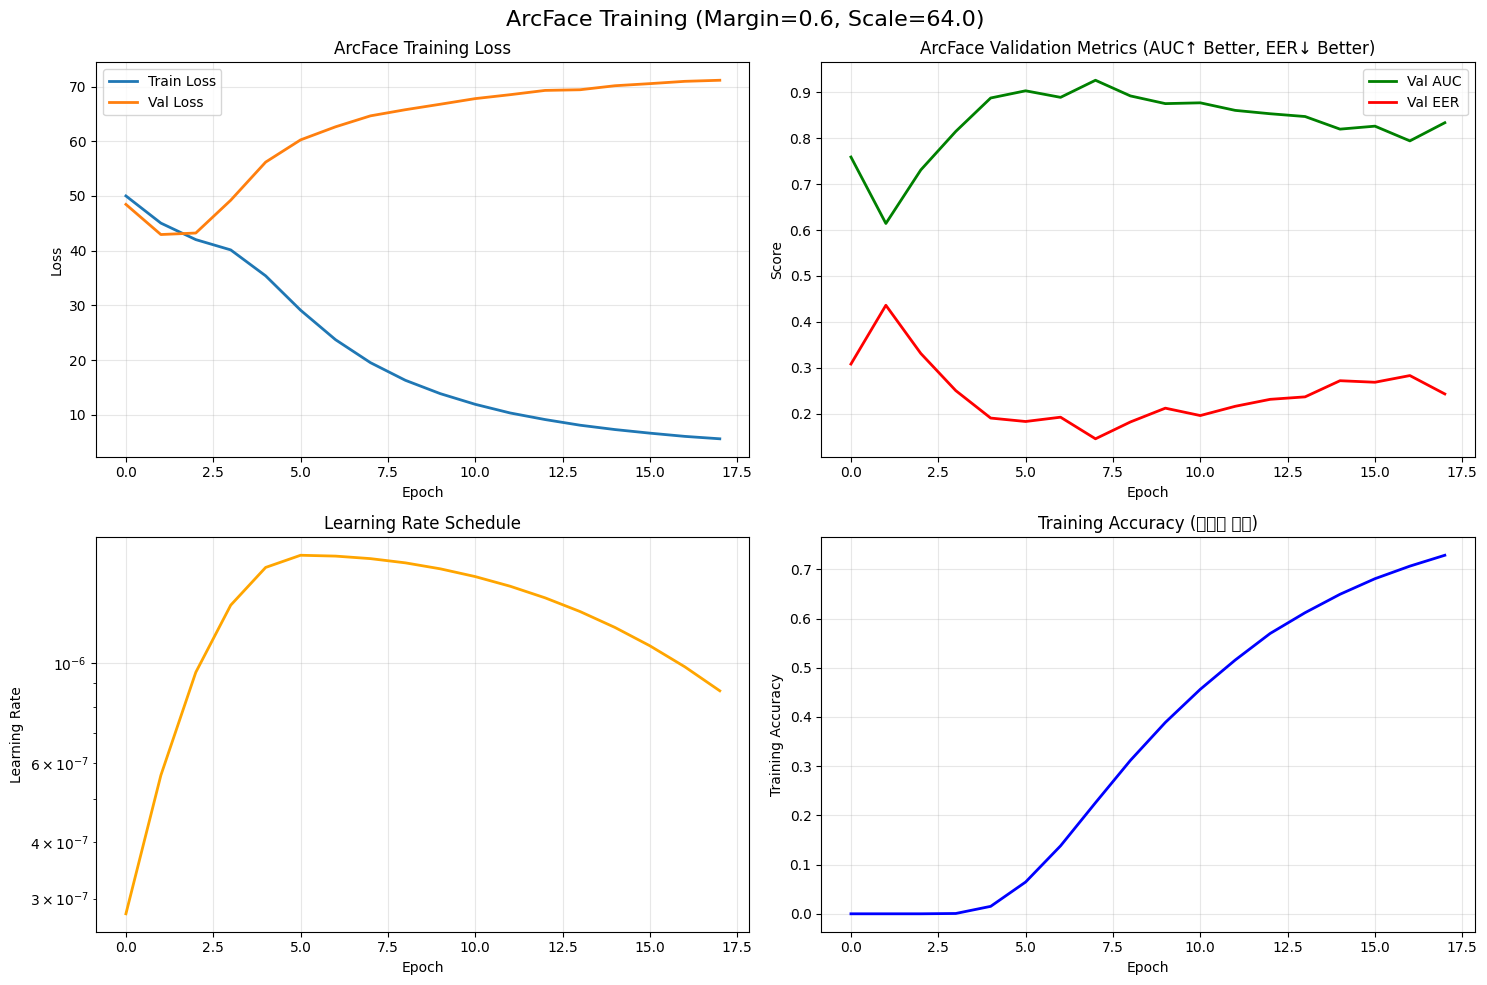


=== 최종 결과 요약 ===
ArcFace 설정: Margin=0.6, Scale=64.0
최고 검증 AUC: 0.9266
최종 학습 정확도: 0.7287
최종 검증 AUC: 0.8341
최종 검증 EER: 0.2429
최종 학습 손실: 5.6040
최종 검증 손실: 71.1552
총 학습 시간: 4.18시간
평균 에폭 시간: 836.1초
사용된 GPU: [2, 3, 4] (총 3개)
효과적인 배치 크기: 192
검증 AUC 개선도: 0.0630 (8.3% 상승)
검증 EER 개선도: 0.0427 (14.1% 감소)


In [8]:
# 학습 곡선 시각화 (AUC/EER 포함 개선된 버전)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 손실 그래프
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('ArcFace Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC/EER 그래프
ax2.plot(history['val_auc'], label='Val AUC', linewidth=2, color='green')
ax2.plot(history['val_eer'], label='Val EER', linewidth=2, color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_title('ArcFace Validation Metrics (AUC↑ Better, EER↓ Better)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 학습률 그래프
ax3.plot(history['learning_rates'], linewidth=2, color='orange')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 학습 정확도 그래프
ax4.plot(history['train_acc'], linewidth=2, color='blue')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Training Accuracy')
ax4.set_title('Training Accuracy (작성자 분류)')
ax4.grid(True, alpha=0.3)

# 전체 제목에 ArcFace 설정 추가
fig.suptitle(f'ArcFace Training (Margin={ARCFACE_MARGIN}, Scale={ARCFACE_SCALE})', fontsize=16)
plt.tight_layout()
plt.savefig(f'/workspace/MIL/output/figures/arcface_training_history_m{margin_str}_s{scale_str}_gpu234.png', dpi=300, bbox_inches='tight')
plt.show()

# 상세한 결과 저장
results = {
    'best_val_auc': float(best_val_auc),
    'final_train_acc': float(history['train_acc'][-1]) if history['train_acc'] else 0.0,
    'final_val_auc': float(history['val_auc'][-1]) if history['val_auc'] else 0.0,
    'final_val_eer': float(history['val_eer'][-1]) if history['val_eer'] else 0.0,
    'final_train_loss': float(history['train_loss'][-1]) if history['train_loss'] else 0.0,
    'final_val_loss': float(history['val_loss'][-1]) if history['val_loss'] else 0.0,
    'total_epochs': len(history['train_loss']),
    'total_training_time': total_time,
    'average_epoch_time': total_time / len(history['train_loss']) if history['train_loss'] else 0,
    'history': history,
    'training_config': {
        'num_epochs': num_epochs,
        'batch_size': optimal_batch_size,
        'effective_batch_size': optimal_batch_size * num_used_gpus if num_used_gpus > 1 else optimal_batch_size,
        'num_gpus': num_used_gpus,
        'gpu_ids': gpu_ids,  # 사용한 GPU ID 추가
        'num_workers': optimal_workers,
        'base_learning_rate': base_lr,
        'adjusted_learning_rate': adjusted_lr,
        'max_learning_rate': adjusted_lr,
        'embedding_dim': 128,
        'num_classes': 300,
        'early_stopping_patience': early_stopping_patience,
        'mixed_precision': True,
        'data_parallel': num_used_gpus > 1,
        'evaluation_metric': 'AUC/EER',
        'arcface_margin': ARCFACE_MARGIN,
        'arcface_scale': ARCFACE_SCALE
    },
    'system_info': {
        'cpu_count': os.cpu_count(),
        'gpu_count': num_gpus,
        'used_gpu_count': num_used_gpus,  # 실제 사용 GPU 수
        'used_gpu_ids': gpu_ids,  # 실제 사용 GPU ID
        'gpu_names': [f"GPU {i}: {torch.cuda.get_device_name(i)}" for i in gpu_ids] if torch.cuda.is_available() else []
    }
}

with open(f'/workspace/MIL/output/results/arcface_training_results_m{margin_str}_s{scale_str}_gpu234.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n=== 최종 결과 요약 ===")
print(f"ArcFace 설정: Margin={ARCFACE_MARGIN}, Scale={ARCFACE_SCALE}")
print(f"최고 검증 AUC: {best_val_auc:.4f}")
print(f"최종 학습 정확도: {history['train_acc'][-1]:.4f}" if history['train_acc'] else "N/A")
print(f"최종 검증 AUC: {history['val_auc'][-1]:.4f}" if history['val_auc'] else "N/A")
print(f"최종 검증 EER: {history['val_eer'][-1]:.4f}" if history['val_eer'] else "N/A")
print(f"최종 학습 손실: {history['train_loss'][-1]:.4f}" if history['train_loss'] else "N/A")
print(f"최종 검증 손실: {history['val_loss'][-1]:.4f}" if history['val_loss'] else "N/A")
print(f"총 학습 시간: {total_time/3600:.2f}시간")
print(f"평균 에폭 시간: {total_time/len(history['train_loss']):.1f}초" if history['train_loss'] else "N/A")
print(f"사용된 GPU: {gpu_ids} (총 {num_used_gpus}개)")
print(f"효과적인 배치 크기: {optimal_batch_size * num_used_gpus if num_used_gpus > 1 else optimal_batch_size}")

# 성능 개선 분석
if len(history['val_auc']) > 5:
    initial_val_auc = np.mean(history['val_auc'][:5])  # 처음 5 에폭 평균
    final_val_auc = np.mean(history['val_auc'][-5:])   # 마지막 5 에폭 평균
    improvement = final_val_auc - initial_val_auc
    print(f"검증 AUC 개선도: {improvement:.4f} ({improvement/initial_val_auc*100:.1f}% 상승)")
    
    initial_val_eer = np.mean(history['val_eer'][:5])  # 처음 5 에폭 평균
    final_val_eer = np.mean(history['val_eer'][-5:])   # 마지막 5 에폭 평균
    eer_improvement = initial_val_eer - final_val_eer
    print(f"검증 EER 개선도: {eer_improvement:.4f} ({eer_improvement/initial_val_eer*100:.1f}% 감소)")

## 8. 테스트 세트 평가

/tmp/ipykernel_28/4172366918.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_to_load.load_state_dict(torch.load(best_model_path, map_location='cpu'))


최고 모델 로드 완료

=== 테스트 세트 임베딩 추출 ===
※ 테스트 세트(240-299번 작성자)는 학습에 사용되지 않았으므로,
   분류 정확도가 아닌 임베딩 품질과 클러스터링 특성을 평가합니다.


Test Embedding Extraction: 100%|██████████| 1133/1133 [01:50<00:00, 10.29it/s]


테스트 임베딩 shape: (72457, 128)
테스트 라벨 수: 60 클래스
테스트 라벨 범위: 240 ~ 299

t-SNE 시각화 생성 중...
t-SNE 입력: 1800 샘플


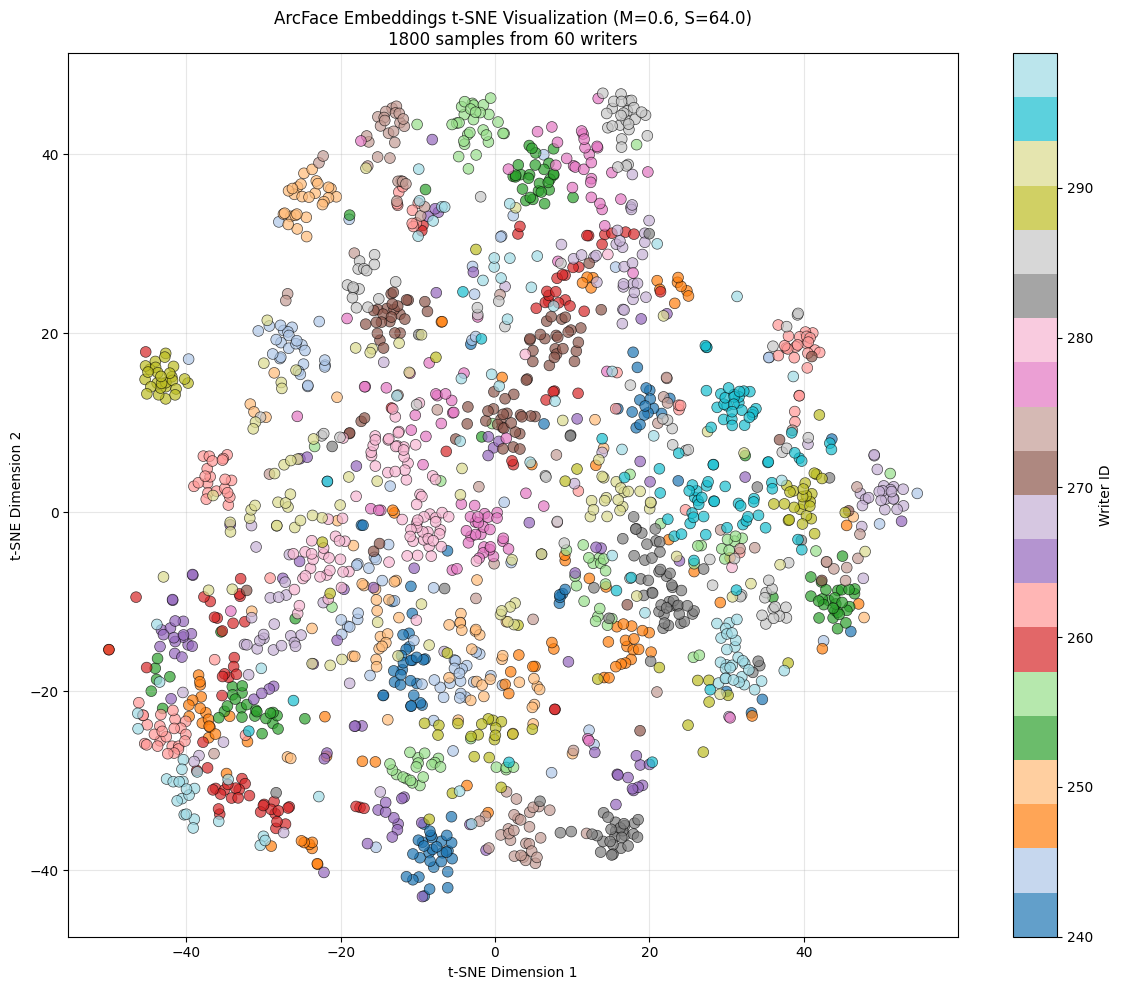


=== 임베딩 품질 분석 ===
같은 작성자 내 평균 유사도: 0.3053 ± 0.1797
다른 작성자 간 평균 유사도: 0.0305 ± 0.1265
분리도 (intra - inter): 0.2748


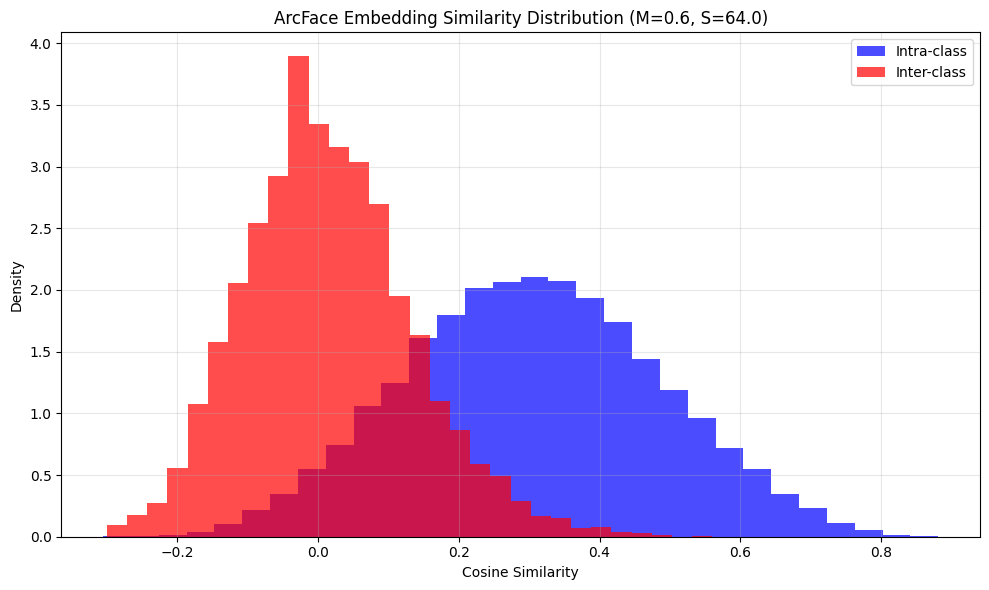


=== ArcFace 모델 학습 및 평가 완료! ===
ArcFace 설정: Margin=0.6, Scale=64.0
모델 저장 위치: /workspace/MIL/output/models/arcface_best_model_m06_s64_gpu234.pth
임베딩 저장 위치: /workspace/MIL/output/models/test_embeddings_arcface_m06_s64_gpu234.npy
결과 저장 위치: /workspace/MIL/output/results/arcface_training_results_m06_s64_gpu234.json
사용한 GPU: [2, 3, 4]


In [9]:
# 최고 모델 로드
model_to_load = ViTArcFace(num_classes=300, embedding_dim=128)  # 300명으로 수정
model_to_load.load_state_dict(torch.load(best_model_path, map_location='cpu'))

# 멀티GPU 환경에서 로드
if num_used_gpus > 1:
    model_to_load = nn.DataParallel(model_to_load, device_ids=gpu_ids)

model_to_load = model_to_load.to(device)
print("최고 모델 로드 완료")

# 테스트 세트 평가 - 임베딩 추출만 수행
print("\n=== 테스트 세트 임베딩 추출 ===")
print("※ 테스트 세트(240-299번 작성자)는 학습에 사용되지 않았으므로,")
print("   분류 정확도가 아닌 임베딩 품질과 클러스터링 특성을 평가합니다.")

model_to_load.eval()
test_embeddings = []
test_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test Embedding Extraction'):
        images = images.to(device, non_blocking=True)
        
        # 임베딩만 추출 (labels=None으로 추론 모드)
        with torch.amp.autocast('cuda'):
            embeddings = model_to_load(images, labels=None)
        
        test_embeddings.append(embeddings.cpu().numpy())
        test_labels.extend(labels.numpy())

test_embeddings = np.vstack(test_embeddings)
test_labels = np.array(test_labels)  # 이미 240-299 범위의 원본 레이블

print(f"테스트 임베딩 shape: {test_embeddings.shape}")
print(f"테스트 라벨 수: {len(np.unique(test_labels))} 클래스")
print(f"테스트 라벨 범위: {test_labels.min()} ~ {test_labels.max()}")

# 테스트 임베딩 저장
np.save(f'/workspace/MIL/output/models/test_embeddings_arcface_m{margin_str}_s{scale_str}_gpu234.npy', test_embeddings)
np.save(f'/workspace/MIL/output/models/test_labels_arcface_m{margin_str}_s{scale_str}_gpu234.npy', test_labels)

# t-SNE 시각화를 위한 샘플링 (계산 효율성을 위해)
from sklearn.manifold import TSNE

print("\nt-SNE 시각화 생성 중...")

# 각 클래스에서 최대 30개씩 샘플링 (더 균등하게)
sampled_indices = []
unique_labels = np.unique(test_labels)
samples_per_class = min(30, len(test_labels) // len(unique_labels))

for label in unique_labels:
    label_indices = np.where(test_labels == label)[0]
    if len(label_indices) > samples_per_class:
        sampled = np.random.choice(label_indices, samples_per_class, replace=False)
    else:
        sampled = label_indices
    sampled_indices.extend(sampled)

sampled_embeddings = test_embeddings[sampled_indices]
sampled_labels = test_labels[sampled_indices]

print(f"t-SNE 입력: {len(sampled_embeddings)} 샘플")

# t-SNE 적용 (최적화된 파라미터)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sampled_embeddings)//4))
embeddings_2d = tsne.fit_transform(sampled_embeddings)

# 향상된 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=sampled_labels, cmap='tab20', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Writer ID')
plt.title(f'ArcFace Embeddings t-SNE Visualization (M={ARCFACE_MARGIN}, S={ARCFACE_SCALE})\n{len(sampled_embeddings)} samples from {len(np.unique(sampled_labels))} writers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'/workspace/MIL/output/figures/arcface_tsne_visualization_m{margin_str}_s{scale_str}_gpu234.png', dpi=300, bbox_inches='tight')
plt.show()

# 임베딩 품질 분석
from sklearn.metrics.pairwise import cosine_similarity

print("\n=== 임베딩 품질 분석 ===")

# 작성자 내/간 유사도 분석
intra_similarities = []  # 같은 작성자 내 유사도
inter_similarities = []  # 다른 작성자 간 유사도

for i, label_i in enumerate(sampled_labels):
    for j, label_j in enumerate(sampled_labels):
        if i < j:  # 중복 방지
            sim = cosine_similarity([sampled_embeddings[i]], [sampled_embeddings[j]])[0][0]
            if label_i == label_j:
                intra_similarities.append(sim)
            else:
                inter_similarities.append(sim)

print(f"같은 작성자 내 평균 유사도: {np.mean(intra_similarities):.4f} ± {np.std(intra_similarities):.4f}")
print(f"다른 작성자 간 평균 유사도: {np.mean(inter_similarities):.4f} ± {np.std(inter_similarities):.4f}")
print(f"분리도 (intra - inter): {np.mean(intra_similarities) - np.mean(inter_similarities):.4f}")

# 유사도 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(intra_similarities, bins=30, alpha=0.7, label='Intra-class', density=True, color='blue')
plt.hist(inter_similarities[:5000], bins=30, alpha=0.7, label='Inter-class', density=True, color='red')  # 샘플링으로 속도 향상
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title(f'ArcFace Embedding Similarity Distribution (M={ARCFACE_MARGIN}, S={ARCFACE_SCALE})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'/workspace/MIL/output/figures/arcface_similarity_distribution_m{margin_str}_s{scale_str}_gpu234.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 GPU 메모리 정리
cleanup_gpu_memory()

print("\n=== ArcFace 모델 학습 및 평가 완료! ===")
print(f"ArcFace 설정: Margin={ARCFACE_MARGIN}, Scale={ARCFACE_SCALE}")
print(f"모델 저장 위치: {best_model_path}")
print(f"임베딩 저장 위치: /workspace/MIL/output/models/test_embeddings_arcface_m{margin_str}_s{scale_str}_gpu234.npy")
print(f"결과 저장 위치: /workspace/MIL/output/results/arcface_training_results_m{margin_str}_s{scale_str}_gpu234.json")
print(f"사용한 GPU: {gpu_ids}")

## 9. 임베딩 추출 및 CSV 저장

학습된 ArcFace 모델을 사용하여 모든 데이터셋(Train/Val/Test)의 임베딩을 추출하고 CSV 형식으로 저장합니다.
이는 MIL Bag 생성을 위해 필요합니다.

In [10]:
def extract_embeddings_to_csv(model, dataloader, dataset, split_name, device, output_dir):
    """
    모델을 사용하여 임베딩을 추출하고 CSV로 저장
    
    Args:
        model: 학습된 ArcFace 모델
        dataloader: 데이터 로더
        dataset: 원본 데이터셋 (경로 정보 접근용)
        split_name: 'train', 'val', 'test' 중 하나
        device: GPU/CPU 디바이스
        output_dir: 출력 디렉토리
    """
    model.eval()
    all_embeddings = []
    all_labels = []
    all_paths = []
    
    print(f"\n{split_name.upper()} 데이터셋 임베딩 추출 중...")
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc=f'{split_name} embedding')):
            images = images.to(device, non_blocking=True)
            
            # 임베딩 추출
            with torch.amp.autocast('cuda'):
                embeddings = model(images, labels=None)
            
            # 배치 내 각 샘플에 대한 정보 수집
            batch_size = images.size(0)
            start_idx = batch_idx * dataloader.batch_size
            
            for i in range(batch_size):
                idx = start_idx + i
                if idx < len(dataset):
                    # 원본 경로 가져오기
                    img_path = dataset.data.iloc[idx]['image_path']
                    all_paths.append(img_path)
            
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 임베딩을 하나의 배열로 결합
    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.array(all_labels)
    
    # 이미 원본 레이블을 사용하고 있으므로 변환 불필요
    
    # DataFrame 생성
    embedding_df = pd.DataFrame(all_embeddings)
    embedding_df.columns = [f'embedding_{i}' for i in range(all_embeddings.shape[1])]
    embedding_df['label'] = all_labels  # 이미 원본 레이블 (0-299 범위)
    embedding_df['path'] = all_paths[:len(all_labels)]  # 경로 개수 맞추기
    
    # 컬럼 순서 조정 (label과 path를 앞으로)
    cols = ['label', 'path'] + [f'embedding_{i}' for i in range(all_embeddings.shape[1])]
    embedding_df = embedding_df[cols]
    
    # CSV 저장
    csv_path = os.path.join(output_dir, f'mil_arcface_{split_name}_data_m{margin_str}_s{scale_str}_gpu234.csv')
    embedding_df.to_csv(csv_path, index=False)
    
    print(f"{split_name.upper()} 임베딩 저장 완료:")
    print(f"- 파일: {csv_path}")
    print(f"- 크기: {embedding_df.shape}")
    print(f"- 라벨 범위: {embedding_df['label'].min()} ~ {embedding_df['label'].max()}")
    print(f"- 고유 라벨 수: {embedding_df['label'].nunique()}")
    
    return embedding_df

# 출력 디렉토리 설정
embedding_output_dir = '/workspace/MIL/data/processed/embeddings'
os.makedirs(embedding_output_dir, exist_ok=True)

# 최고 모델 다시 로드 (임베딩 추출용)
print("=== 임베딩 추출을 위한 모델 준비 ===")
print(f"ArcFace 설정: Margin={ARCFACE_MARGIN}, Scale={ARCFACE_SCALE}")
best_model = ViTArcFace(num_classes=300, embedding_dim=128)  # 300명으로 수정
best_model.load_state_dict(torch.load(best_model_path, map_location='cpu'))

# 멀티GPU 설정
if num_used_gpus > 1:
    best_model = nn.DataParallel(best_model, device_ids=gpu_ids)

best_model = best_model.to(device)
best_model.eval()

# 임베딩 추출용 데이터로더 생성 (shuffle=False로 순서 보장)
train_loader_for_extraction = DataLoader(
    train_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False,  # 순서 유지를 위해 False로 설정
    num_workers=optimal_workers,
    pin_memory=True,
    persistent_workers=True
)

# 각 데이터셋에 대해 임베딩 추출 및 CSV 저장
train_embeddings_df = extract_embeddings_to_csv(
    best_model, train_loader_for_extraction, train_dataset, 'train', device, embedding_output_dir
)

# val_loader와 test_loader는 이미 shuffle=False이므로 그대로 사용
val_embeddings_df = extract_embeddings_to_csv(
    best_model, val_loader, val_dataset, 'val', device, embedding_output_dir
)

test_embeddings_df = extract_embeddings_to_csv(
    best_model, test_loader, test_dataset, 'test', device, embedding_output_dir
)

print("\n=== 모든 임베딩 CSV 저장 완료! ===")
print(f"ArcFace 설정: Margin={ARCFACE_MARGIN}, Scale={ARCFACE_SCALE}")
print(f"저장 위치: {embedding_output_dir}")
print("생성된 파일:")
print(f"- mil_arcface_train_data_m{margin_str}_s{scale_str}_gpu234.csv (0-179)")
print(f"- mil_arcface_val_data_m{margin_str}_s{scale_str}_gpu234.csv (180-239)")
print(f"- mil_arcface_test_data_m{margin_str}_s{scale_str}_gpu234.csv (240-299)")
print(f"사용한 GPU: {gpu_ids}")

=== 임베딩 추출을 위한 모델 준비 ===
ArcFace 설정: Margin=0.6, Scale=64.0


/tmp/ipykernel_28/2746569359.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, map_location='cpu'))



TRAIN 데이터셋 임베딩 추출 중...


train embedding: 100%|██████████| 3254/3254 [05:08<00:00, 10.56it/s]


TRAIN 임베딩 저장 완료:
- 파일: /workspace/MIL/data/processed/embeddings/mil_arcface_train_data_m06_s64_gpu234.csv
- 크기: (208233, 130)
- 라벨 범위: 0 ~ 179
- 고유 라벨 수: 180

VAL 데이터셋 임베딩 추출 중...


val embedding: 100%|██████████| 1103/1103 [01:44<00:00, 10.59it/s]


VAL 임베딩 저장 완료:
- 파일: /workspace/MIL/data/processed/embeddings/mil_arcface_val_data_m06_s64_gpu234.csv
- 크기: (70533, 130)
- 라벨 범위: 180 ~ 239
- 고유 라벨 수: 60

TEST 데이터셋 임베딩 추출 중...


test embedding: 100%|██████████| 1133/1133 [01:47<00:00, 10.49it/s]


TEST 임베딩 저장 완료:
- 파일: /workspace/MIL/data/processed/embeddings/mil_arcface_test_data_m06_s64_gpu234.csv
- 크기: (72457, 130)
- 라벨 범위: 240 ~ 299
- 고유 라벨 수: 60

=== 모든 임베딩 CSV 저장 완료! ===
ArcFace 설정: Margin=0.6, Scale=64.0
저장 위치: /workspace/MIL/data/processed/embeddings
생성된 파일:
- mil_arcface_train_data_m06_s64_gpu234.csv (0-179)
- mil_arcface_val_data_m06_s64_gpu234.csv (180-239)
- mil_arcface_test_data_m06_s64_gpu234.csv (240-299)
사용한 GPU: [2, 3, 4]


## 10. 임베딩 품질 검증

CSV로 저장된 임베딩의 품질을 간단히 검증합니다.

In [11]:
# 저장된 CSV 파일 검증
print("=== 저장된 CSV 파일 검증 ===")

# 각 CSV 파일 확인
for split in ['train', 'val', 'test']:
    csv_path = os.path.join(embedding_output_dir, f'mil_arcface_{split}_data.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"\n{split.upper()} 데이터:")
        print(f"- 파일 크기: {os.path.getsize(csv_path) / (1024*1024):.2f} MB")
        print(f"- 데이터 shape: {df.shape}")
        print(f"- 임베딩 차원: {len([col for col in df.columns if col.startswith('embedding_')])}")
        print(f"- 첫 5개 컬럼: {df.columns[:5].tolist()}")
        print(f"- 라벨 분포: {df['label'].value_counts().shape[0]} 클래스")
        
        # 샘플 데이터 확인
        print(f"- 샘플 데이터:")
        print(df[['label', 'path']].head(3))
    else:
        print(f"\n{split.upper()} CSV 파일이 없습니다: {csv_path}")

# 임베딩 통계 확인
print("\n=== 임베딩 통계 ===")
train_df_check = pd.read_csv(os.path.join(embedding_output_dir, 'mil_arcface_train_data.csv'))
embedding_cols = [col for col in train_df_check.columns if col.startswith('embedding_')]
embedding_values = train_df_check[embedding_cols].values

print(f"임베딩 평균: {np.mean(embedding_values):.4f}")
print(f"임베딩 표준편차: {np.std(embedding_values):.4f}")
print(f"임베딩 최소값: {np.min(embedding_values):.4f}")
print(f"임베딩 최대값: {np.max(embedding_values):.4f}")

# L2 norm 확인 (ArcFace는 정규화된 임베딩을 생성해야 함)
norms = np.linalg.norm(embedding_values, axis=1)
print(f"\n임베딩 L2 norm:")
print(f"- 평균: {np.mean(norms):.4f}")
print(f"- 표준편차: {np.std(norms):.4f}")
print(f"- 최소값: {np.min(norms):.4f}")
print(f"- 최대값: {np.max(norms):.4f}")

print("\n=== ArcFace 임베딩 추출 및 CSV 저장 완료! ===")
print("\n다음 단계:")
print("1. mil_data_generator2_arcface.ipynb를 실행하여 MIL Bag 생성")
print("2. AB_MIL_arcface_128d.ipynb를 생성하여 MIL 모델 학습")
print("3. 다른 임베딩 방법(Siamese, Autoencoder)과 성능 비교")

=== 저장된 CSV 파일 검증 ===

TRAIN 데이터:
- 파일 크기: 307.72 MB
- 데이터 shape: (208233, 130)
- 임베딩 차원: 128
- 첫 5개 컬럼: ['label', 'path', 'embedding_0', 'embedding_1', 'embedding_2']
- 라벨 분포: 180 클래스
- 샘플 데이터:
   label           path
0      0  0/'YX'_17.png
1      0   0/-he_10.png
2      0    0/-ne_9.png

VAL 데이터:
- 파일 크기: 104.30 MB
- 데이터 shape: (70533, 130)
- 임베딩 차원: 128
- 첫 5개 컬럼: ['label', 'path', 'embedding_0', 'embedding_1', 'embedding_2']
- 라벨 분포: 60 클래스
- 샘플 데이터:
   label               path
0    180  180/'Y.X.'_13.png
1    180  180/'Y.X.'_16.png
2    180  180/'Y.X.'_17.png

TEST 데이터:
- 파일 크기: 107.16 MB
- 데이터 shape: (72457, 130)
- 임베딩 차원: 128
- 첫 5개 컬럼: ['label', 'path', 'embedding_0', 'embedding_1', 'embedding_2']
- 라벨 분포: 60 클래스
- 샘플 데이터:
   label               path
0    240  240/'X.X.'_10.png
1    240   240/'Y.X'_13.png
2    240  240/'Y.X.'_18.png

=== 임베딩 통계 ===
임베딩 평균: -0.0006
임베딩 표준편차: 0.0884
임베딩 최소값: -0.4181
임베딩 최대값: 0.4207

임베딩 L2 norm:
- 평균: 1.0000
- 표준편차: 0.0000
- 최소값: 1.0000
- 최대값: 1